<a href="https://colab.research.google.com/github/Aminfaraji/segmentaion_document_Unet/blob/main/document%20segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import glob
import nibabel
import matplotlib.pyplot as plt
from skimage.util import montage
import os
from keras.preprocessing.image import load_img,img_to_array
import keras as K

In [ ]:
# !pip install -q kaggle
# !mkdir ~/.kaggle 
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c ultrasound-nerve-segmentation

In [3]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00306/dataset_segmentation.rar
# !unrar x /content/dataset_segmentation.rar

In [10]:
images=glob.glob("/content/dataset_segmentation/*.jpg")
mask=glob.glob("/content/dataset_segmentation/*.png")
train_image=[]
train_mask=[]
for i in range(len(images)):
  img=load_img(images[i],target_size=(256,256))
  mask_=load_img(images[i][:-4]+"_m.png",target_size=(256,256))
  train_image.append(img_to_array(img))
  train_mask.append(img_to_array(mask_))
  # print(images[i],"+++++",images[i][:-4]+"_m.png")
train_image=np.array(train_image)/255
train_mask=np.array(train_mask)/255

In [21]:
input_=K.Input((256,256,3))
conv1=K.layers.Conv2D(32,3,activation='relu',padding='same')(input_)
conv1=K.layers.Conv2D(32,3,activation='relu',padding='same')(conv1)
pool1=K.layers.MaxPool2D()(conv1)

conv2=K.layers.Conv2D(64,3,activation='relu',padding='same')(pool1)
conv2=K.layers.Conv2D(64,3,activation='relu',padding='same')(conv2)
pool2=K.layers.MaxPool2D()(conv2)

conv3=K.layers.Conv2D(128,3,activation='relu',padding='same')(pool2)
conv3=K.layers.Conv2D(128,3,activation='relu',padding='same')(conv3)
pool3=K.layers.MaxPool2D()(conv3)

conv4=K.layers.Conv2D(256,3,activation='relu',padding='same')(pool3)
conv4=K.layers.Conv2D(256,3,activation='relu',padding='same')(conv4)
pool4=K.layers.MaxPool2D()(conv4)

conv5=K.layers.Conv2D(512,3,activation='relu',padding='same')(pool4)
conv5=K.layers.Conv2D(512,3,activation='relu',padding='same')(conv5)
pool5=K.layers.MaxPool2D()(conv5)

u6=K.layers.concatenate([K.layers.Conv2DTranspose(256,(2,2),(2,2),padding="same")(conv5),conv4],axis=3)
conv6=K.layers.Conv2D(256,3,activation="relu",padding="same")(u6)
conv6=K.layers.Conv2D(256,3,activation="relu",padding="same")(conv6)

u7=K.layers.concatenate([K.layers.Conv2DTranspose(128,2,(2,2),padding="same")(conv6),conv3],axis=3)
conv7=K.layers.Conv2D(128,3,activation="relu",padding="same")(u7)
conv7=K.layers.Conv2D(128,3,activation="relu",padding="same")(conv7)

u8=K.layers.concatenate([K.layers.Conv2DTranspose(64,2,(2,2),padding="same")(conv7),conv2],axis=3)
conv8=K.layers.Conv2D(64,3,activation="relu",padding="same")(u8)
conv8=K.layers.Conv2D(64,3,activation="relu",padding="same")(conv8)


u9=K.layers.concatenate([K.layers.Conv2DTranspose(32,2,(2,2),padding="same")(conv8),conv1],axis=3)
conv9=K.layers.Conv2D(32,3,activation="relu",padding="same")(u9)
conv9=K.layers.Conv2D(32,3,activation="relu",padding="same")(conv9)

conv10=K.layers.Conv2D(3,3,activation="softmax",padding="same")(conv9)

model=K.Model([input_],[conv10])


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [28]:
def jucard(y_true,y_pred):
  y_true_f=K.backend.flatten(y_true)
  y_pred_f=K.backend.flatten(y_pred)
  intersection=K.backend.sum(y_true_f*y_pred_f)
  return (2*intersection+3)/(K.backend.flatten(y_pred_f)+K.backend.flatten(y_true_f)+3)
def acc(y_true,y_pred):
  return -jucard(y_true,y_pred)
model.compile('rmsprop',loss=jucard,metrics=[acc])

In [29]:
model.fit(train_image,train_mask,batch_size=32,epochs=2)

Epoch 1/2
3/3 [==============================] - 83s 22s/step - loss: 817131.0469 - acc: -817131.0000
Epoch 2/2
3/3 [==============================] - 75s 21s/step - loss: 818650.4062 - acc: -818650.4062


In [30]:
pred=model.predict(train_image[0:1])

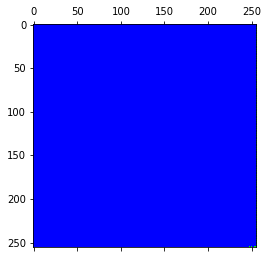

In [31]:
plt.matshow(pred[0])